In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data Preparation for Food-Fruit Binary Classification

Making sure there is no fruit in the food folder

In [2]:
fruits= os.listdir('Project Data/Fruit/Train/')
foods= os.listdir('Project Data/Food/Train/')

In [3]:
for fruit in fruits:
    if fruit in foods:
        print(f"Conflict found: {fruit} is in both folders.")

In [4]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Load the Training images

In [5]:
def ignore_masks(path):
    return "mask" not in path.lower()

In [6]:
food_dataset = datasets.ImageFolder(
    root="Project Data/Food/Train",
    transform=transforms,
    target_transform=lambda y: 0,
    )

fruit_dataset = datasets.ImageFolder(
    root="Project Data/Fruit/Train",
    transform=transforms,
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks
    )

full_train_dataset = ConcatDataset([food_dataset, fruit_dataset])

print(f"Total Training Images: {len(full_train_dataset)}")

train_loader = DataLoader(
    dataset=full_train_dataset,    
    batch_size=32,
    shuffle=True,
    num_workers=2
)

Total Training Images: 4297


Load the Testing images

In [7]:
val_food = datasets.ImageFolder(
    "Project Data/Food/Validation",
    transform=transforms,
    target_transform=lambda y: 0
)
val_fruit = datasets.ImageFolder(
    "Project Data/Fruit/Validation",
    transform=transforms,
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks     
    )

full_val_dataset = ConcatDataset([val_food, val_fruit])

val_loader = DataLoader(
    full_val_dataset, 
    batch_size=32, 
    shuffle=False
)

## Let's visualize a batch of training data

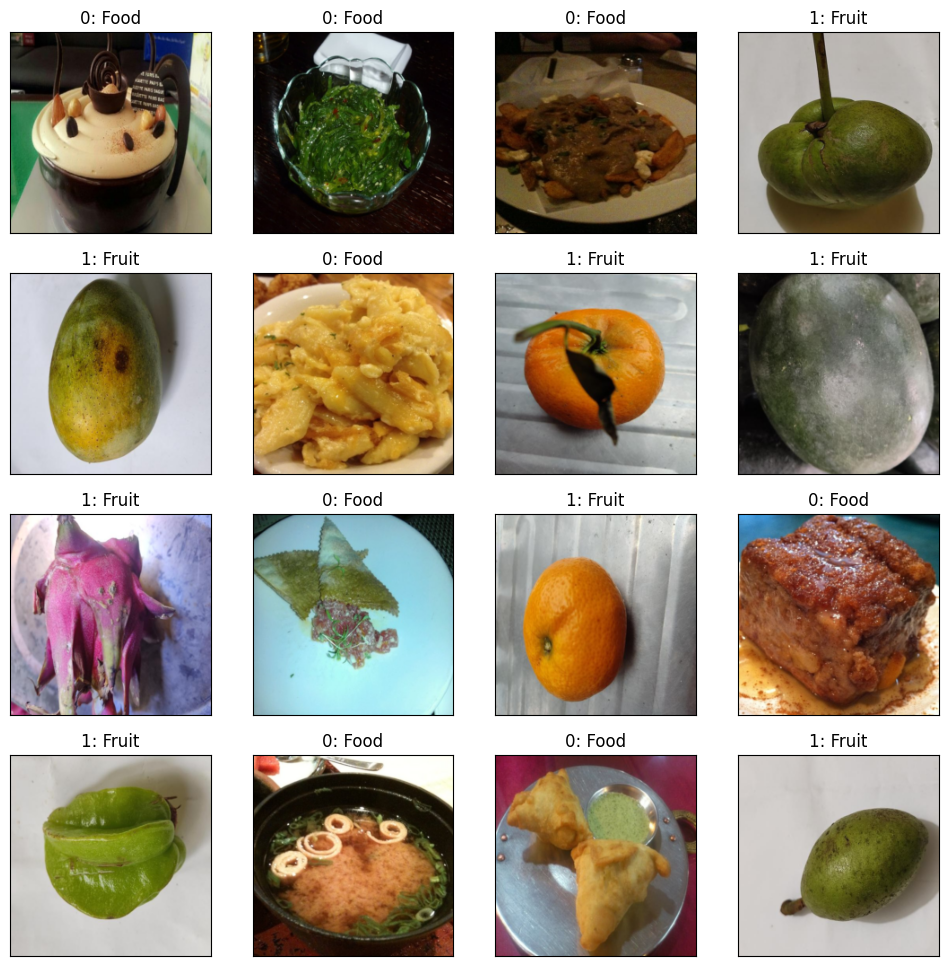

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

class_names = {0: 'Food', 1: 'Fruit'}
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    label_id = labels[i].item()
    ax.set_title(f"{label_id}: {class_names[label_id]}")

plt.show()